# Plotting fishnet from previously extracted data

## 1. Installing the dependencies

Following libraries are used to perform geospatial analysis using this code:

    1. Matplotlib
    2. Geopandas
    3. Shapely
    
You can install geopandas from [here](https://geopandas.org/en/stable/getting_started/install.html). While installing geopandas, all other dependencies like shapely will also get installed.

In [1]:
# uncomment the code below and run this cell to install matplotlib if there is no matplotlib on your system/Virtual environment
# !pip install matplotlib --quiet

## 2. Importing the dependencies and data

In [2]:
# following dependencies will be used to perform analysis

import geopandas as gpd
from shapely.geometry import Point, Polygon
from geopandas import GeoDataFrame
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from shapely import wkt
import seaborn as sns
from tqdm import tqdm

In [ ]:
# using pandas to read the parquet file

df = pd.read_parquet(r"2019_Nepal_data.parquet")

Pandas operates on two principles: Fit on memory and single core execution. This means that, if the dataset like above is larger than your system memory, then pandas can't handle such data. Additionally, pandas cannnot utilize parallel processing.

There is an alternative to pandas called [Dask](https://docs.dask.org/en/stable/dataframe.html) which solves the above mentioned problems.

## 3. Filtering Nepal's data and creating polygon for each data point

In [4]:
# # the shapefile below should contain the bounding area of nepal.

bounding_cordinates_of_nepal = gpd.read_file(r"nepals_bounding_cordinate.shp")

In [6]:
# the shapefile, after loading in the geopandas dataframe, should look like this

bounding_cordinates_of_nepal

,OBJECTID,Shape_Leng,Shape_Area,geometry
0,1,33.362281,13.61287,"POLYGON ((80.60614 30.46697, 80.60738 30.46690..."


<AxesSubplot:>

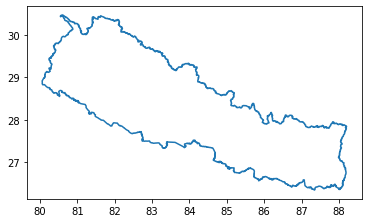

In [7]:
# plotting the dataframe

bounding_cordinates_of_nepal.geometry.boundary.plot()

In [12]:
df.head()

,ColumnAmountNO2Trop,Latitude,Longitude,Cloud_Fraction,QA_Value,Date,Time,LAT1,LAT2,LAT3,LAT4,LON1,LON2,LON3,LON4,OBJECTID,Shape_Leng,Shape_Area
0,1.512665e+15,26.387493,87.594284,0.203,100.0,2019-01-01,06-41-59,26.353701,26.358072,26.421289,26.416922,87.571136,87.630699,87.617554,87.557961,1,33.362281,13.61287
1,1.668753e+15,26.413187,87.961197,0.170,100.0,2019-01-01,06-41-59,26.379496,26.383690,26.446880,26.442692,87.936348,87.999130,87.986191,87.923378,1,33.362281,13.61287
2,1.394956e+15,26.417362,88.024284,0.140,100.0,2019-01-01,06-41-59,26.383690,26.387852,26.451040,26.446880,87.999130,88.062485,88.049583,87.986191,1,33.362281,13.61287
3,1.065985e+15,26.419495,87.175659,0.222,100.0,2019-01-01,06-41-59,26.385578,26.390135,26.453377,26.448822,87.154282,87.210571,87.197144,87.140823,1,33.362281,13.61287
4,6.186839e+14,26.424036,87.232185,0.216,100.0,2019-01-01,06-41-59,26.390135,26.394667,26.457905,26.453377,87.210571,87.267303,87.253906,87.197144,1,33.362281,13.61287


From the above dataframe, we can clearly see that for every data point, there are 4 pairs of latitude and longitude. We will use these 4 cordinates to create a shapely polygon. For a nth  grid in the selected fishnet shape file, we will check if a data point's polygon intersects with the nth grid. This way, all the data points whose polygons intersects with the nth grid will be considered for that grid. Finally, the average from all those data points is calculated for the nth grid. This way, averaging will be done for <b>TROPOMI</b>.

Before proceeding further, there is one operation we need to perform. While extracting the data for Nepal, we only saved the data points whose latitude and longitude lied in the range [25, 32, 80, 89]. The data of Nepal is the subset of the extracted data because there is probably data for northern india and southern china in that parquet data. Therefore, we need to only select data points from the parquet files whose latitude and longitude lie inside the <b> bounding_cordinates_of_nepal </b>.

In [17]:
# creating the geometry column containing shapely point object using Longitudes and Latitudes

df['geometry'] = gpd.points_from_xy(df['Longitude'], df['Latitude'])
df = df.set_geometry('geometry')
df = df.set_crs('EPSG:4326')

In [19]:
# this will perform spatial join of the two dataframes such that only data points inside nepal will be returned
df = gpd.sjoin(df, bounding_cordinates_of_nepal, op = 'within').reset_index(drop = True)

C:\Users\Lenovo\anaconda3\envs\geo_env\lib\site-packages\IPython\core\interactiveshell.py:3191: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


<b>If you wish to know more about geopandas.GeoDataFrame.sjoin, proceed to the following [link](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html).

In [20]:
def get_polygon(row):
    return Polygon([(row['LON1'], row['LAT1']), (row['LON2'], row['LAT2']),(row['LON3'], row['LAT3']), (row['LON4'], row['LAT4'])])

In [54]:
# creating the polygon for each data point.
# All of these polygons will be checked for intersection with fishnet grids

df['rectangle'] = df.apply(get_polygon, axis = 1)
df = df.set_geometry('rectangle')

In [22]:
# filtering data using QA_Value and ColumnAmountNO2Trop
# here, only those data are considered whose qa value is > 75

df = df[(df.QA_Value > 75) & (df.ColumnAmountNO2Trop > -0.5e15)].reset_index(drop = True)

# 4. Loading Nepal's fishnet and calculating average

In [23]:
# this is fishnet shape file where each uniform grid has area roughly 1*1 km2.

fishnet_x = gpd.read_file(r"Nepal_1km_Clp.shp", float_precision='round_trip')
fishnet_x = fishnet_x.to_crs('EPSG:4326')

In [24]:
fishnet_x

,Id,geometry
0,0,"POLYGON ((84.30246 27.96454, 84.29230 27.96434..."
1,0,"POLYGON ((86.04011 26.84118, 86.04004 26.85021..."
2,0,"POLYGON ((85.98030 26.77756, 85.99036 26.77764..."
3,0,"POLYGON ((86.68391 26.96146, 86.69399 26.96148..."
4,0,"POLYGON ((86.43153 27.05998, 86.42145 27.05993..."
...,...,...
150427,0,"POLYGON ((87.50854 26.60878, 87.49850 26.60881..."
150428,0,"POLYGON ((87.28738 26.53716, 87.27735 26.53718..."
150429,0,"POLYGON ((85.72967 26.70332, 85.72957 26.71235..."
150430,0,"POLYGON ((87.17714 26.65472, 87.17713 26.64569..."


<b> I will mention two methods to calculate average for each grid: </b>
       
       1. Using for loop
       
       2. Using built-in geopandas method and groupby aggregate function

In [26]:
# Extracting month from date
df['Month'] = df.Date.dt.month

<b> I will only select a sample of the entire data. You can proceed with entire data

In [29]:
df.groupby('Month')['ColumnAmountNO2Trop'].count()

Month
1     62117
2     44528
3     66731
4     54818
5     58533
6     39429
7     15953
8     28931
9     25003
10    63589
11    80537
12    89919
Name: ColumnAmountNO2Trop, dtype: int64

<b> Since june has least amount of data, I will proceed with june's data in this notebook for visualization purpose.</b>

In [55]:
df1 = df[df.Month == 7].reset_index(drop = True)

In [56]:
df1.Month.unique()

array([7], dtype=int64)

### 4.1 Using for loop

In [58]:
%%time

# Initializing an empty numpy array to hold averages for each fishnet grid
average = np.array([], dtype = np.float64)

# putting all fishnet grids in an array 
geom = fishnet_x.geometry

# looping through each fishnet grids
for j in tqdm(range(0,len(fishnet_x))):
    
    # checking all data points in df1 whose polygons intersect with jth fishnet grid
    ''' The function intersects returns boolean value. So, for the rows with value true, their indexes will be used to 
        select only those rows'''
    a = df1.intersects(geom[j]) 
    
    # calculating average from the data points whose polygons intersect the jth fishnet grid and appending the
    # value to average numpy array
    average = np.append(average,df1.loc[a[a].index].ColumnAmountNO2Trop.mean())

100%|█████████████████████████████████████████████████████████████████████████| 150432/150432 [06:28<00:00, 387.19it/s]

CPU times: total: 6min 29s
Wall time: 6min 28s


In [61]:
# saving the output
fishnet_x['outputs_of_for_loop'] = average

In [62]:
fishnet_x

,Id,geometry,outputs_of_for_loop,ID,geopandas_overlay
0,0,"POLYGON ((84.30246 27.96454, 84.29230 27.96434...",8.991300e+14,1,NaN
1,0,"POLYGON ((86.04011 26.84118, 86.04004 26.85021...",1.294962e+15,2,NaN
2,0,"POLYGON ((85.98030 26.77756, 85.99036 26.77764...",1.564602e+15,3,1.888178e+15
3,0,"POLYGON ((86.68391 26.96146, 86.69399 26.96148...",7.496200e+14,4,NaN
4,0,"POLYGON ((86.43153 27.05998, 86.42145 27.05993...",NaN,5,NaN
...,...,...,...,...,...
150427,0,"POLYGON ((87.50854 26.60878, 87.49850 26.60881...",1.127192e+15,150428,NaN
150428,0,"POLYGON ((87.28738 26.53716, 87.27735 26.53718...",1.275559e+15,150429,NaN
150429,0,"POLYGON ((85.72967 26.70332, 85.72957 26.71235...",1.563769e+15,150430,NaN
150430,0,"POLYGON ((87.17714 26.65472, 87.17713 26.64569...",1.260302e+15,150431,2.021698e+15


<b> Almost 7 minutes for averaging data of a month. This is not good at all. So, we will proceed to calculate the average using 
another method.

### 4.2 Using geopandas.overlay

If you wish to learn more about how geopandas.overlay works, proceed to following [link](https://geopandas.org/en/stable/docs/reference/api/geopandas.GeoDataFrame.sjoin.html)

In [63]:
# the funtion below will simply return NaN for those fishnet grids where none of the polygons intersected

from collections import OrderedDict
def get_ordered_dict(dx, IDs):
    for id_ in IDs:
        if id_ not in dx.keys():
            dx[id_] = np.nan
    
    dict1 = dict(OrderedDict(sorted(dx.items())))
    return np.array(list(dict1.values()))

# assigning an id to each fishnet grid, which will be used to identify grids while calculating average
fishnet_x['ID'] = range(1, fishnet_x.shape[0]+1)

In [64]:
%%time

# performing geopandas.overlay to get all datapoints whole polygons intersect with each fishnet grid
result = gpd.overlay(df1 ,fishnet_x, how='intersection')

# averaging the datapoints, whose polygons intersected with fishnet grids, using groupby aggregate funtion
fishnet_x['geopandas_overlay']  = get_ordered_dict(dict(result.groupby('ID', \
                                dropna = False)['ColumnAmountNO2Trop'].mean()), fishnet_x['ID'])

CPU times: total: 37.7 s
Wall time: 37.7 s


<b> WoW. geopandas.overlay took 37.7 seconds whereas standard for loop took almost 7 minutes. 
    
geopandas.overlay is roughly <b> 12 times faster</b> than for loop in this particular case.

<b> lets check if both outputs are same or not first

In [65]:
fishnet_x['outputs_of_for_loop'].equals(fishnet_x['geopandas_overlay'])

True

The output from both methods is exactly the same. Now that we have calculated averages for july, lets plot the data over Nepal.

# 5. Plotting

In [68]:
province = gpd.read_file(r"province_shape_file_of_nepal.shp")
nepal = gpd.read_file(r"bounding_cordinates_shape_file_of_nepal.shp")
district = gpd.read_file(r"district_shape_file_of_nepal.shp")

In [67]:
''' The following code applies cosmetics to the names of districts and provinces effectively making them look better in map.'''

district['size'] = district.DISTRICT
checklist= ['Kathmandu', 'Bhaktapur', 'Lalitpur', 'Rukum West', 'Rukum East', 'Parbat', 'Ramechhap']
district['size'] = district['size'].apply(lambda x : x[:2] if x not in checklist else x)
district.loc[district['size'] == 'Kathmandu', 'size'] = '1'
district.loc[district['size'] == 'Bhaktapur', 'size'] = '2'
district.loc[district['size'] == 'Lalitpur', 'size'] = '3'
district.loc[district['size'] == 'Rukum West', 'size'] = 'R W'
district.loc[district['size'] == 'Rukum East', 'size'] = 'R E'
district.loc[district['size'] == 'Parbat', 'size'] = '4'
district.loc[district['size'] == 'Ramechhap', 'size'] = ''
province['province'] = province.PR_NAME
province.loc[province['province'] == 'Province No 2', 'province'] = ''
province.loc[province['province'] == 'Province No 5', 'province'] = ''

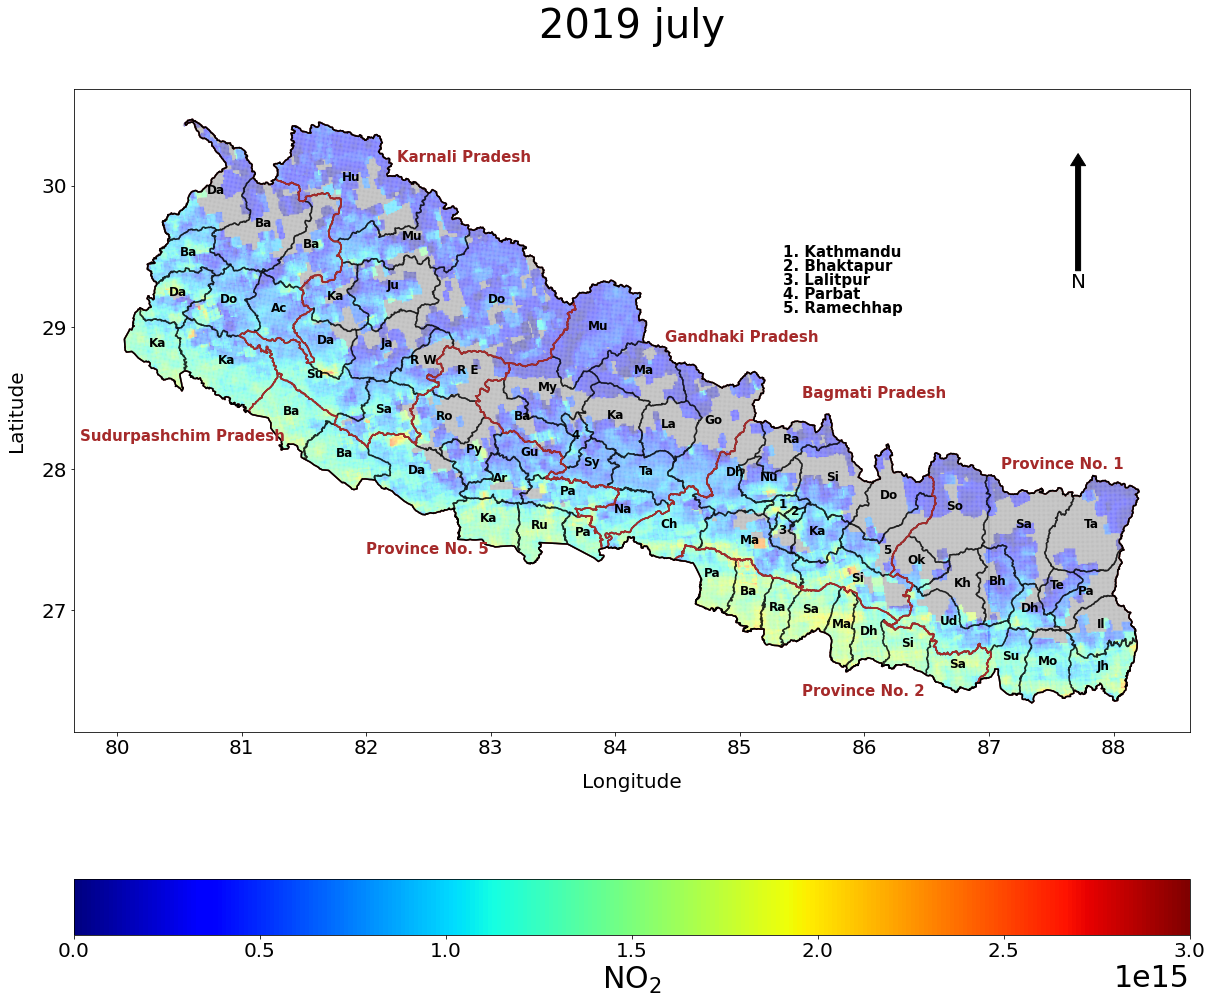

In [69]:
fig, ax = plt.subplots(figsize=(20, 18))
plt.rcParams.update({'font.size': 30}) # legend ko title ko size

ax1 = district.geometry.boundary.plot(ax = ax, edgecolor = 'black', alpha = 0.6)
district.apply(lambda x: ax1.annotate(text=x['size'], xy=x.geometry.centroid.coords[0],ha='center', fontsize = 12
                                      , color = 'black',fontweight='bold', alpha = 1), axis=1);
ax.text(86.15, 27.4, '5', fontsize=12, color = 'black',fontweight='bold', alpha = 1)
ax.text(85.35, 29.5, '1. Kathmandu', fontsize=15, color = 'black',fontweight='bold')
ax.text(85.35, 29.4, '2. Bhaktapur', fontsize=15, color = 'black',fontweight='bold')
ax.text(85.35, 29.3, '3. Lalitpur', fontsize=15, color = 'black',fontweight='bold')
ax.text(85.35, 29.2, '4. Parbat', fontsize=15, color = 'black',fontweight='bold')
ax.text(85.35, 29.1, '5. Ramechhap', fontsize=15, color = 'black',fontweight='bold')

ax2 = province.geometry.boundary.plot(ax = ax, edgecolor = 'brown', alpha = 1)
ax.text(82, 27.4, 'Province No. 5', fontsize = 15, color = 'brown', fontweight='bold')
ax.text(85.5, 26.40, 'Province No. 2', fontsize = 15, color = 'brown', fontweight='bold')
ax.text(87.1, 28.0, 'Province No. 1', fontsize = 15, color = 'brown', fontweight='bold')
ax.text(85.5, 28.5, 'Bagmati Pradesh', fontsize = 15, color = 'brown', fontweight='bold')
ax.text(84.4, 28.9, 'Gandhaki Pradesh', fontsize = 15, color = 'brown', fontweight='bold')
ax.text(82.25, 30.17, 'Karnali Pradesh', fontsize = 15, color = 'brown', fontweight='bold') # 
ax.text(79.7, 28.2, 'Sudurpashchim Pradesh', fontsize = 15, color = 'brown', fontweight='bold')

ax3 = nepal.geometry.boundary.plot(ax = ax, edgecolor = 'black', alpha = 1)

ax.xaxis.set_tick_params(labelsize=20)
ax.yaxis.set_tick_params(labelsize=20)


vmin = 0e+15
vmax = 3e+15

fishnet_x.plot(ax= ax, column = 'geopandas_overlay', cmap = 'jet',linewidth = 0,alpha = 0.5, edgecolor = 'black',legend = True, 
               legend_kwds={'shrink': 1,'label': 'NO$_2$','orientation' : 'horizontal'}, 
               missing_kwds = dict(color='grey', label='No Data'),
                markersize = 10, vmin = vmin, vmax = vmax)

ax.tick_params(labelsize=20)
legend = fig.axes[1]
legend.tick_params(labelsize = 20)
x, y, arrow_length = 0.9, 0.9, 0.2
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=5, headwidth=15),
            ha='center', va='center', fontsize=20,
            xycoords=ax.transAxes)
plt.xlabel("Longitude", fontsize = 20, labelpad = 15)
plt.ylabel("Latitude", fontsize = 20, labelpad = 15)
plt.text(0.5, 1.08, '2019 july',
        horizontalalignment='center',
        fontsize=40,
        transform = ax.transAxes);


# uncomment the code below to save the plot
# plt.savefig('name_of_the_plot.jpg',  bbox_inches='tight', dpi = 300)

<b> This way, geoepandas can be used to perform geospatial analysis.